In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import arrow
from pathlib import Path
import netCDF4 as nc
import pandas as pd
import datetime as dt
from cmocean import cm
from salishsea_tools import viz_tools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gsw

In [22]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask0 = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
meshmask = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
tmask0 = meshmask0.tmask
mbathy0 = meshmask0.mbathy
tmask1 = meshmask.tmask
mbathy1 = meshmask.mbathy

mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
depth = mesh.variables['gdept_0'][:]


### ONC observations

In [23]:
# Obs cordonates (Saanich Inlet, Sill) : 48.691697°N, -123.500042°W, 94m
df_Sil = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Sill/O2Sensor_20120226_20210101_clean_avg1day_SIS_edit.csv')
df_Sil2 = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Sill/CTD_Salinity_20120226_20210101_clean_avg1day_SIS_edit.csv')
# Obs cordonates (Saanich Inlet, Patricia Bay) : 48.651366°N, -123.486358°W, 95m
df_PaB = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/Oxygen_RinkoSensor_20100221_20210101_clean_avg1day_SI_edit.csv')
df_PaB2 = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/CTDA_Salinity_20100101_20210101_clean_avg1day_SI_edit.csv')
# Obs cordonates: SoG Center: 49.039467°N, -123.425033°W, 300m ; SoG Est: 49.042586°N,  -123.316579°W, 166m
df_SoG = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/O2Sensor_20100101_20210101_clean_avg1day_SoGC_edit.csv')
df_SoG2 = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/CTD_Salinity_20100101_20210101_clean_avg1day_SoGC_edit.csv')

In [24]:
# Convert objet dataframe to int
df_Sil['oxy_sil'] = pd.to_numeric(df_Sil['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_PaB['oxy_pab'] = pd.to_numeric(df_PaB['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_SoG['oxy_sog'] = pd.to_numeric(df_SoG['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_Sil2['sal_sil'] = pd.to_numeric(df_Sil2['Practical Salinity (psu)'], errors='coerce')
df_PaB2['sal_pab'] = pd.to_numeric(df_PaB2['Practical Salinity (psu)'], errors='coerce')
df_SoG2['sal_sog'] = pd.to_numeric(df_SoG2['Practical Salinity (psu)'], errors='coerce')
df_Sil['time'] = pd.to_datetime(df_Sil['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
df_PaB['time'] = pd.to_datetime(df_PaB['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
df_SoG['time'] = pd.to_datetime(df_SoG['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
df_Sil2['time'] = pd.to_datetime(df_Sil2['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
df_PaB2['time'] = pd.to_datetime(df_PaB2['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
df_SoG2['time'] = pd.to_datetime(df_SoG2['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"'])
# from practical to ref salinity (g/kg)
df_Sil2['sal_sil'] = gsw.SR_from_SP(df_Sil2['sal_sil']) 
df_PaB2['sal_pab'] = gsw.SR_from_SP(df_PaB2['sal_pab'])
df_SoG2['sal_sog'] = gsw.SR_from_SP(df_SoG2['sal_sog'])


In [25]:
jj_sil = grid_lons_lats.jj.sel(lats=48.691697, lons=-123.500042, method='nearest') # 93 m (Obs)
ii_sil = grid_lons_lats.ii.sel(lats=48.691697, lons=-123.500042, method='nearest')
jj_pab = grid_lons_lats.jj.sel(lats=48.651366, lons=-123.486358, method='nearest') # 93 m (Obs)
ii_pab = grid_lons_lats.ii.sel(lats=48.651366, lons=-123.486358, method='nearest')
jj_sog = grid_lons_lats.jj.sel(lats=49.039467, lons=-123.425033, method='nearest') # 305 m (Obs)
ii_sog = grid_lons_lats.ii.sel(lats=49.039467, lons=-123.425033, method='nearest')

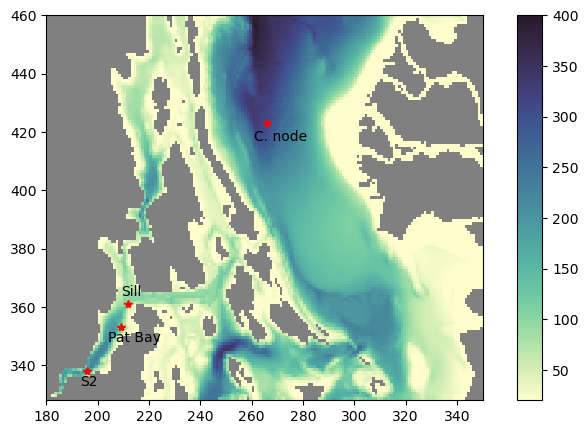

In [26]:
jj_S2, ii_S2 = (338, 196) #max depth in Saanich
line, col = (1, 1)
fig, ax = plt.subplots(line, col, figsize=(10, 5))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.set_xlim([180, 350])
ax.set_ylim([328, 460])
vmin,vmax=(20,400)
im = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=vmin, vmax=vmax)
ax.plot(ii_sil, jj_sil,'r*') # Patricia bay
ax.text(ii_sil-3, jj_sil+3,'Sill')
ax.plot(ii_pab, jj_pab,'r*')
ax.text(ii_pab-5, jj_pab-5, 'Pat Bay')
ax.plot(ii_S2, jj_S2,'r*')
ax.text(ii_S2-3, jj_S2-5, 'S2')
ax.plot(ii_sog, jj_sog,'r*')
ax.text(ii_sog-5, jj_sog-6, 'C. node')
viz_tools.set_aspect(ax);
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [27]:
print(df_Sil.time[0],df_PaB.time[0],df_SoG.time[0])

2012-02-26 12:00:00+00:00 2010-02-21 12:00:00+00:00 2010-01-01 12:00:00+00:00


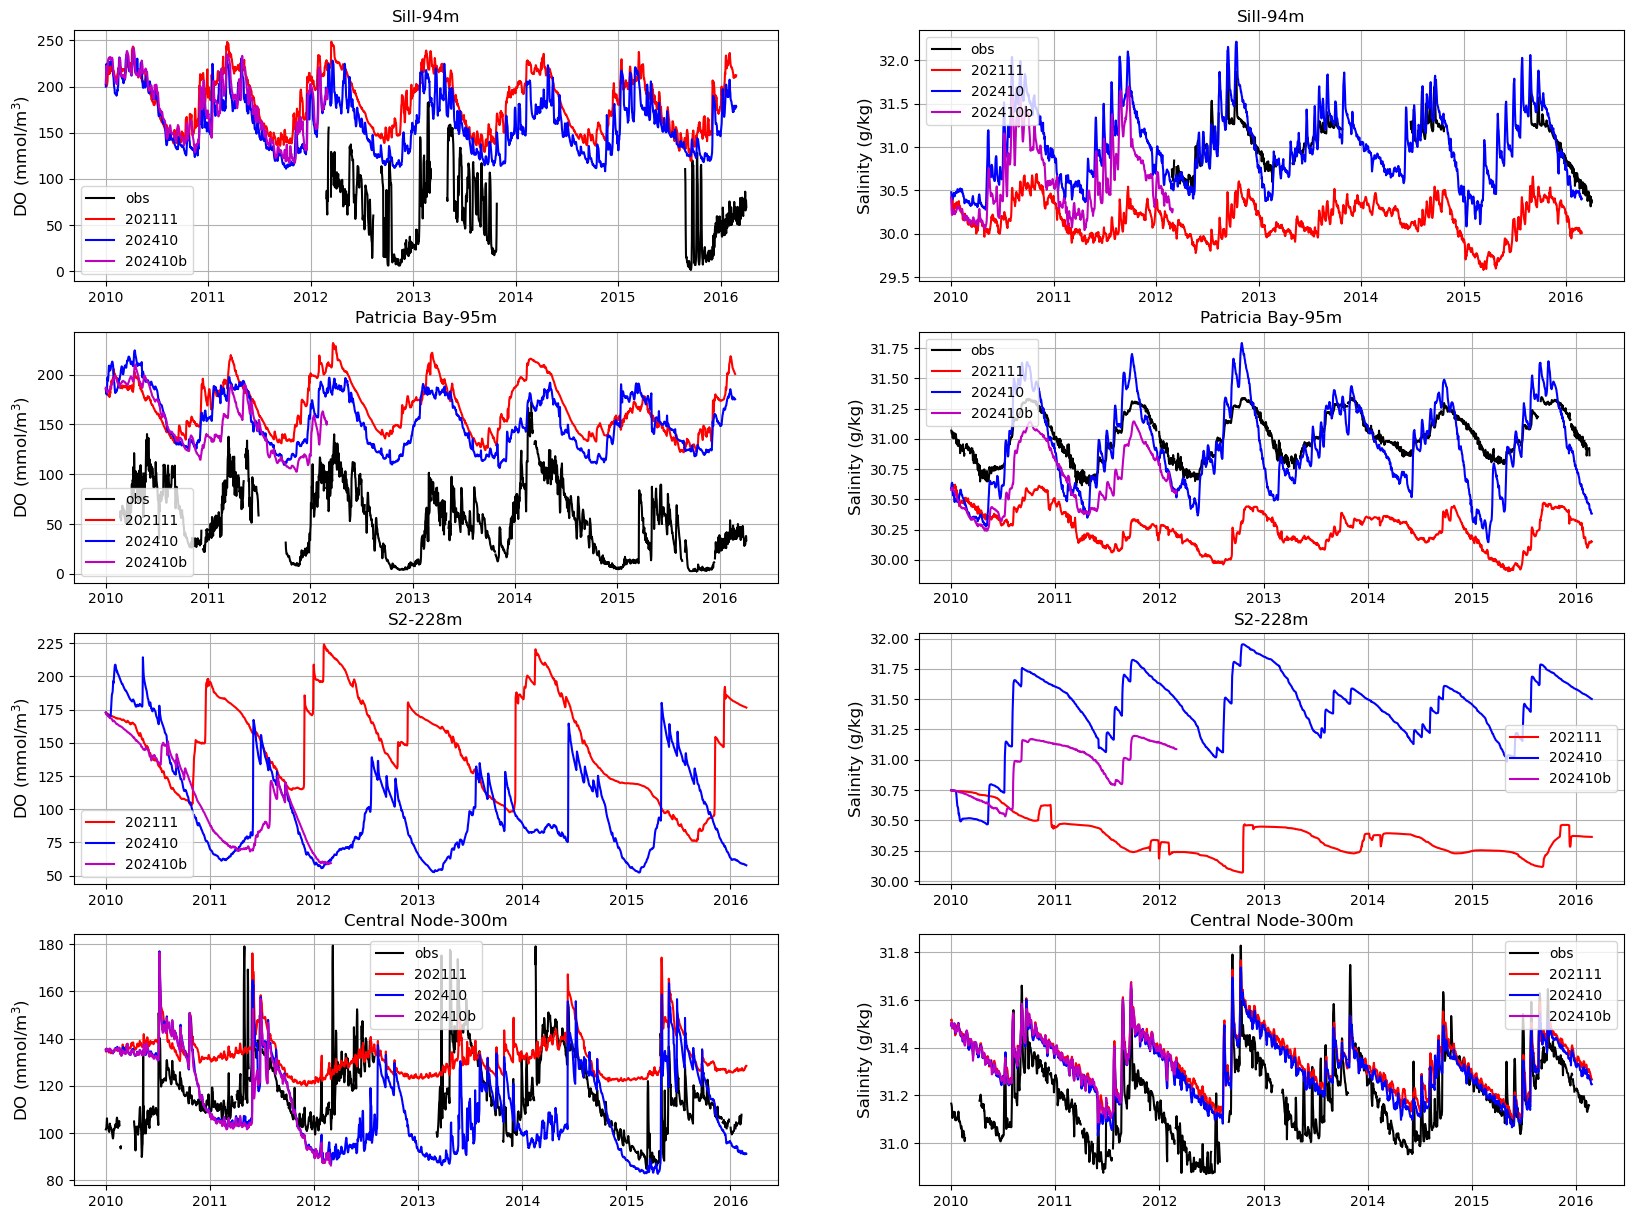

In [28]:
line, col = (4, 2)
fig, ax = plt.subplots(line, col, figsize=(20, 15))
place = list(['Sill-94m','Patricia Bay-95m','S2-228m','Central Node-300m'])
ylabel = list(['DO (mmol/m$^3$)','Salinity (g/kg)'])
t3=365*6+1+59
t2=t3-20
t1=t3-756
ax[0,0].plot(df_Sil.time[:t1],df_Sil.oxy_sil[:t1] * 44.661, 'k', label='obs')
ax[1,0].plot(df_PaB.time[:t2],df_PaB.oxy_pab[:t2] * 44.661, 'k', label='obs')
ax[3,0].plot(df_SoG.time[:t2],df_SoG.oxy_sog[:t2] * 44.661, 'k', label='obs')
ax[0,1].plot(df_Sil2.time[:t1],df_Sil2.sal_sil[:t1], 'k', label='obs')
ax[1,1].plot(df_PaB2.time[:t2],df_PaB2.sal_pab[:t2], 'k', label='obs')
ax[3,1].plot(df_SoG2.time[:t2],df_SoG2.sal_sog[:t2], 'k', label='obs')
syear, smonth, sday = (2010, 1, 1)
eyear, emonth, eday = (2016, 2, 25)
for alpha in range(0, 3):
    if alpha == 0:
        dir = '/results2/SalishSea/nowcast-green.202111/'
        colors = 'r'
        labels = '202111'
        mbathy,tmask=(mbathy0,tmask0)
    elif alpha == 1:
        dir = '/ocean/sallen/timbucktwo/oxygen/'
        colors = 'b'
        labels = '202410'
        mbathy,tmask=(mbathy1,tmask1)
    elif alpha == 2:
        dir = '/ocean/atall/MOAD/Model/202410b/oxygen/'
        colors = 'm'
        labels = '202410b'
        mbathy,tmask=(mbathy1,tmask1)
        eyear, emonth, eday = (2012, 2, 29)
    startdate = arrow.get(syear, smonth, sday)
    enddate = arrow.get(eyear, emonth, eday)    
    for j in range(0, line):
        if j==0:
            jj, ii = (jj_sil, ii_sil)
        elif j==1:
            jj, ii = (jj_pab, ii_pab)
        elif j==2:
            jj, ii = (jj_S2, ii_S2)
        else:
            jj, ii = (jj_sog, ii_sog)
        first = True
        for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
            year = day.year
            yr2 = day.strftime("%y")
            month = day.month
            Month = day.strftime("%b").lower()
            day = day.day
            # set up filename to follow NEMO conventions
            fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
            fgrdT = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
            with xr.open_dataset(fchem) as ds_chem:
                oxy0 = ds_chem['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            with xr.open_dataset(fgrdT) as ds_grdT:
                sal0 = ds_grdT['vosaline'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            if 'time' in ds_chem.variables.keys():
                continue
            if first:
                first = False
                oxy = oxy0
                sal = sal0
            else:
                oxy = xr.concat([oxy, oxy0], dim='time_counter')
                sal = xr.concat([sal, sal0], dim='time_counter')
        vars = list([oxy,sal])
        for i in range(0,len(vars)):
            ax[j,i].plot(vars[i].time_counter, vars[i], color=colors, label=labels)
            ax[j,i].legend()
            ax[j,i].set_ylabel(f'{ylabel[i]}',fontsize=12)
            ax[j,i].set_title(f'{place[j]}',fontsize=12)
            ax[j,i].grid()